<a href="https://colab.research.google.com/github/antonpolishko/A_colab_collection/blob/master/SEIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request

In [ ]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0,e_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.e_0 = e_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('data/time_series_19-covid-Confirmed-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('data/time_series_19-covid-Recovered-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('data/time_series_19-covid-Deaths-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self,alpha, beta, gamma, data, recovered, death, country, s_0,e_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SEIR(t, y):
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            return [-beta*S*I,beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SEIR, [0, size], [s_0,e_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.15,0.8, 0.33], args=(data, recovered, self.s_0,self.e_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4),(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        alpha,beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(alpha,beta, gamma, data, recovered, death, self.country, self.s_0,self.e_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0],'Exposed':prediction.y[1],'Infected': prediction.y[2], 'Recovered': prediction.y[3]}, index=new_index)
        print(df.tail(5))
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country},alpha={alpha:.8f} beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")


def loss(point, data, recovered, s_0,e_0, i_0, r_0):
    size = len(data)
    alpha,beta, gamma = point
    def SIR(t, y):
        S = y[0]
        E = y[1]
        I = y[2]
        R = y[3]
        return [-beta*S*I,beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,e_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha_1 = 0.1
    return alpha_1 * l1 + (1 - alpha_1) * l2


In [ ]:
learner = Learner("China", loss, "1/31/20", 150, 10000, 4,1, 0)

      fun: 997.8727024602608
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.09494702e-05, -4.27878604e+00, -5.12508791e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 10
   status: 0
  success: True
        x: array([0.04750767, 0.4       , 0.4       ])
         Infected data Recovered data  ...  Infected    Recovered
06/24/20          None           None  ...  1.392920  9993.272042
06/25/20          None           None  ...  1.328293  9993.816178
06/26/20          None           None  ...  1.266665  9994.335067
06/27/20          None           None  ...  1.207896  9994.829885
06/28/20          None           None  ...  1.151854  9995.301746

[5 rows x 7 columns]
country=China,alpha=0.04750767 beta=0.40000000, gamma=0.40000000, r_0:1.00000000


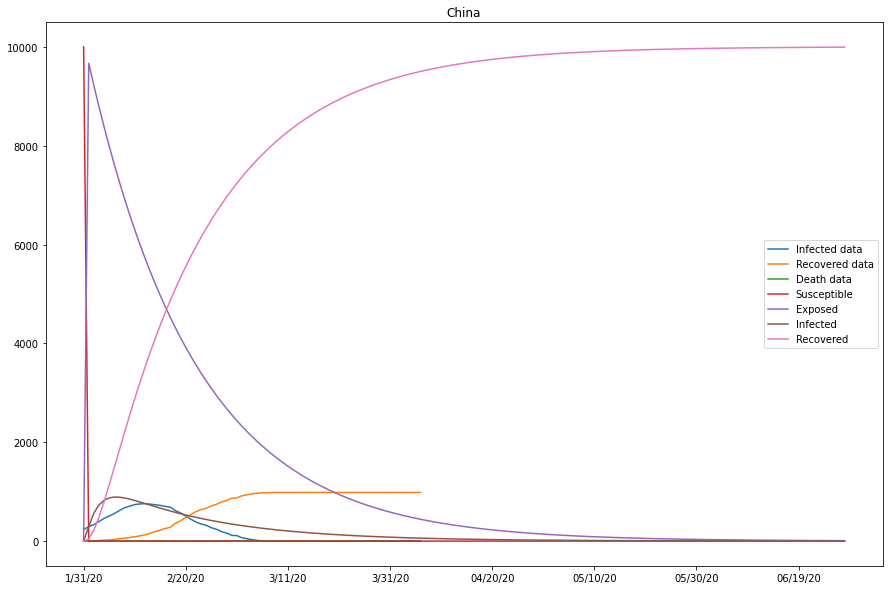

In [ ]:
learner.train()